In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from sklearn.datasets import load_files

from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from pprint import pprint
import pickle
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


[nltk_data] Downloading package stopwords to /home/cst/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cst/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cst/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def read_text_file(category,file_name):
    path = directory+category+'/'+file_name
    f = open(path, "r", encoding="utf8", errors='ignore')
    return f.read()


In [3]:
directory = 'data/bbc/'
data = {}
x = [item for item in os.walk(directory)]
categories = x[0][1]

In [4]:
# categories = [x[0].split('/')[1] for x in os.walk(directory) if x[0].split('/')[1]!='']
categories_df = pd.DataFrame(categories, columns=['category'])

In [5]:
df = pd.DataFrame()
for cat in categories:    
    files_df = pd.DataFrame(os.listdir(directory+cat+'/'), columns=['file_name'])
    files_df['category'] = cat
    df = pd.concat([df, files_df])    
    print(cat)
    print(df.columns)
    print(df.shape)
    print(df.head())
    print('------------------------------------------')
    
    
    

entertainment
Index(['file_name', 'category'], dtype='object')
(386, 2)
  file_name       category
0   118.txt  entertainment
1   220.txt  entertainment
2   165.txt  entertainment
3   232.txt  entertainment
4   051.txt  entertainment
------------------------------------------
business
Index(['file_name', 'category'], dtype='object')
(896, 2)
  file_name       category
0   118.txt  entertainment
1   220.txt  entertainment
2   165.txt  entertainment
3   232.txt  entertainment
4   051.txt  entertainment
------------------------------------------
sport
Index(['file_name', 'category'], dtype='object')
(1407, 2)
  file_name       category
0   118.txt  entertainment
1   220.txt  entertainment
2   165.txt  entertainment
3   232.txt  entertainment
4   051.txt  entertainment
------------------------------------------
tech
Index(['file_name', 'category'], dtype='object')
(1808, 2)
  file_name       category
0   118.txt  entertainment
1   220.txt  entertainment
2   165.txt  entertainment
3   232.t

In [6]:
df['complete-filename'] = df['file_name']+'-'+df['category']

In [7]:
df['content'] = df.apply(lambda x: read_text_file(x['category'], x['file_name']), axis=1)

In [8]:
df['news_length'] = df['content'].str.len()

In [9]:
df.groupby(['category']).size()

category
business         510
entertainment    386
politics         417
sport            511
tech             401
dtype: int64

In [10]:
df['category'].value_counts(normalize=True)

sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: category, dtype: float64

In [11]:
df

,file_name,category,complete-filename,content,news_length
0,118.txt,entertainment,118.txt-entertainment,REM concerts blighted by illness\n\nUS rock ba...,1460
1,220.txt,entertainment,220.txt-entertainment,New media battle for Bafta awards\n\nThe BBC l...,1649
2,165.txt,entertainment,165.txt-entertainment,Comic Morris returns with sitcom\n\nComedian C...,1051
3,232.txt,entertainment,232.txt-entertainment,Connick Jr to lead Broadway show\n\nSinger and...,1135
4,051.txt,entertainment,051.txt-entertainment,Foxx and Swank win US awards\n\nJamie Foxx and...,1965
...,...,...,...,...,...
412,412.txt,politics,412.txt-politics,'Last chance' warning for voters\n\nPeople in ...,1414
413,392.txt,politics,392.txt-politics,'No UK apology' for colonial past\n\nThe days ...,1932
414,173.txt,politics,173.txt-politics,Ministers lose slopping out case\n\nThe Scotti...,2494
415,284.txt,politics,284.txt-politics,Kennedy's cautious optimism\n\nCharles Kennedy...,3742


In [12]:
df[df['news_length']<np.quantile(df['news_length'],0.95)]['news_length']

0      1460
1      1649
2      1051
3      1135
4      1965
       ... 
412    1414
413    1932
414    2494
415    3742
416    2082
Name: news_length, Length: 2113, dtype: int64

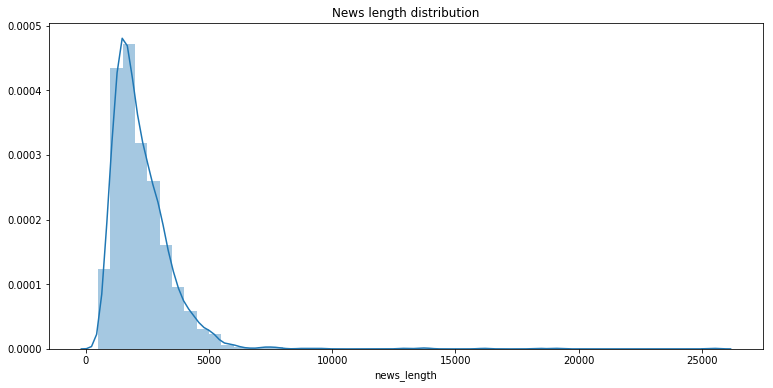

In [13]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['news_length']).set_title('News length distribution');

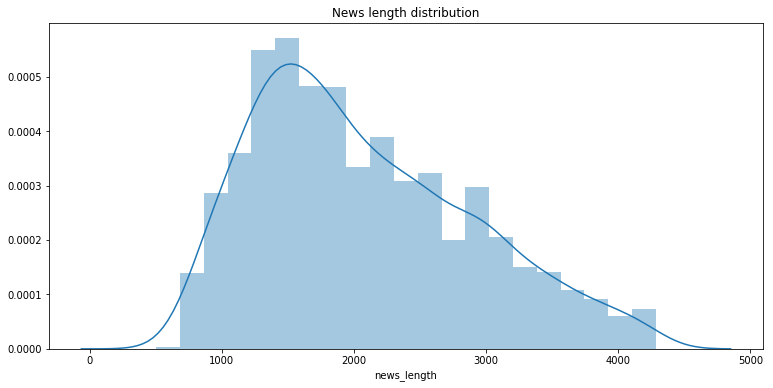

In [14]:
plt.figure(figsize=(12.8,6))
sns.distplot(df[df['news_length']<np.quantile(df['news_length'],0.95)]['news_length']).set_title('News length distribution');

In [15]:
print(df[df['news_length'] > 10000].shape)
print(df[df['news_length'] > 5000].shape)

(7, 5)
(53, 5)


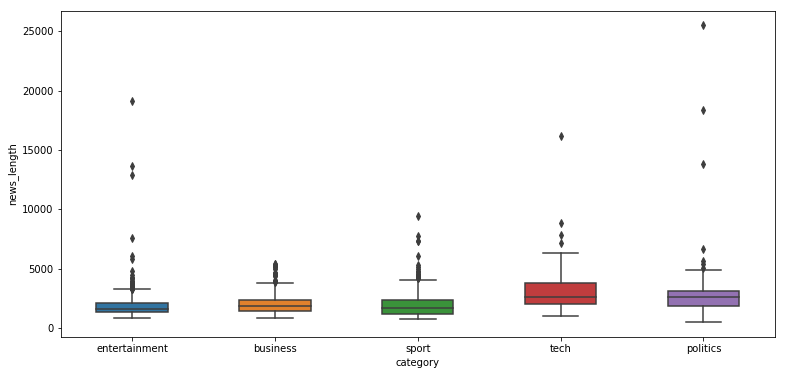

In [16]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='category', y='news_length', width=.5);

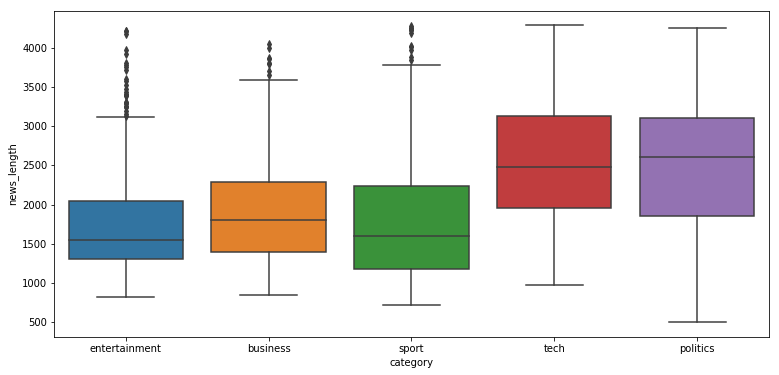

In [17]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df[df['news_length']<np.quantile(df['news_length'],0.95)], x='category', y='news_length');

In [18]:
with open('news_dataset.pickle', 'wb') as output:
    pickle.dump(df, output)

In [19]:
df.to_csv('data/bbc_clean.csv',index=False)

In [20]:
df.iloc[1]['content']

'New media battle for Bafta awards\n\nThe BBC leads the nominations for the Bafta Interactive Awards, including one for the Radio Times website and one for Sport Interactive\'s Euro 2004 coverage.\n\nThe awards, which were started in 1997, recognise the best websites, digital TV shows and CD roms. Other nominees include The Guardian news website, the National Theatre, MTV, the Science Museum and the London Stock Exchange. The winners from 12 different categories are crowned on 2 March 2005. There were nearly 400 entries this year - a third more than last year. The BBC has 16 nominations while The Guardian has three nominations.\n\n"This year\'s nominees are a testament to the creative and innovative work going on within the industry," said Grant Dean, chair of the interactive committee. Categories include interactive TV, film, digital TV, mobile phones and music. Shaun of the Dead, Oasis\' Definitely Maybe, Really Bend It Like Beckham, The Chaplin Collection and The Day Today will batt

# 1. Text cleaning and preparation

## 1.1. Special character cleaning

We can see the following special characters:

- \r
- \n
- \ before possessive pronouns (government's = government\'s)
- \ before possessive pronouns 2 (Yukos' = Yukos\')
- " when quoting text

In [21]:
df['Content_Parsed_1'] = df['content'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

In [22]:
df

,file_name,category,complete-filename,content,news_length,Content_Parsed_1
0,118.txt,entertainment,118.txt-entertainment,REM concerts blighted by illness\n\nUS rock ba...,1460,REM concerts blighted by illness US rock band...
1,220.txt,entertainment,220.txt-entertainment,New media battle for Bafta awards\n\nThe BBC l...,1649,New media battle for Bafta awards The BBC lea...
2,165.txt,entertainment,165.txt-entertainment,Comic Morris returns with sitcom\n\nComedian C...,1051,Comic Morris returns with sitcom Comedian Chr...
3,232.txt,entertainment,232.txt-entertainment,Connick Jr to lead Broadway show\n\nSinger and...,1135,Connick Jr to lead Broadway show Singer and a...
4,051.txt,entertainment,051.txt-entertainment,Foxx and Swank win US awards\n\nJamie Foxx and...,1965,Foxx and Swank win US awards Jamie Foxx and H...
...,...,...,...,...,...,...
412,412.txt,politics,412.txt-politics,'Last chance' warning for voters\n\nPeople in ...,1414,'Last chance' warning for voters People in En...
413,392.txt,politics,392.txt-politics,'No UK apology' for colonial past\n\nThe days ...,1932,'No UK apology' for colonial past The days of...
414,173.txt,politics,173.txt-politics,Ministers lose slopping out case\n\nThe Scotti...,2494,Ministers lose slopping out case The Scottish...
415,284.txt,politics,284.txt-politics,Kennedy's cautious optimism\n\nCharles Kennedy...,3742,Kennedy's cautious optimism Charles Kennedy i...


- Regarding 3rd and 4th bullet, although it seems there is a special character, it won't affect us since it is not a real character:

In [23]:
text = "Mr Greenspan\'s"
text

"Mr Greenspan's"

In [24]:
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')

In [25]:
df

,file_name,category,complete-filename,content,news_length,Content_Parsed_1
0,118.txt,entertainment,118.txt-entertainment,REM concerts blighted by illness\n\nUS rock ba...,1460,REM concerts blighted by illness US rock band...
1,220.txt,entertainment,220.txt-entertainment,New media battle for Bafta awards\n\nThe BBC l...,1649,New media battle for Bafta awards The BBC lea...
2,165.txt,entertainment,165.txt-entertainment,Comic Morris returns with sitcom\n\nComedian C...,1051,Comic Morris returns with sitcom Comedian Chr...
3,232.txt,entertainment,232.txt-entertainment,Connick Jr to lead Broadway show\n\nSinger and...,1135,Connick Jr to lead Broadway show Singer and a...
4,051.txt,entertainment,051.txt-entertainment,Foxx and Swank win US awards\n\nJamie Foxx and...,1965,Foxx and Swank win US awards Jamie Foxx and H...
...,...,...,...,...,...,...
412,412.txt,politics,412.txt-politics,'Last chance' warning for voters\n\nPeople in ...,1414,'Last chance' warning for voters People in En...
413,392.txt,politics,392.txt-politics,'No UK apology' for colonial past\n\nThe days ...,1932,'No UK apology' for colonial past The days of...
414,173.txt,politics,173.txt-politics,Ministers lose slopping out case\n\nThe Scotti...,2494,Ministers lose slopping out case The Scottish...
415,284.txt,politics,284.txt-politics,Kennedy's cautious optimism\n\nCharles Kennedy...,3742,Kennedy's cautious optimism Charles Kennedy i...


## 1.2. Upcase/downcase

In [26]:
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()

## 1.3. Punctuation signs

In [27]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')

By doing this we are messing up with some numbers, but it's no problem since we aren't expecting any predicting power from them.

## 1.4. Possessive pronouns

We'll also remove possessive pronoun terminations:

In [28]:
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")

## 1.5. Stemming and Lemmatization

Since stemming can produce output words that don't exist, we'll only use a lemmatization process at this moment. Lemmatization takes into consideration the morphological analysis of the words and returns words that do exist, so it will be more useful for us.

In [29]:
wordnet_lemmatizer = WordNetLemmatizer()

In order to lemmatize, we have to iterate through every word:

In [30]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.iloc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [31]:
df['Content_Parsed_5'] = lemmatized_text_list

Although lemmatization doesn't work perfectly in all cases (as can be seen in the example below), it can be useful.

## 1.6. Stop words

In [32]:
stop_words = list(stopwords.words('english'))

In [33]:
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

To remove the stop words, we'll handle a regular expression only detecting whole words, as seen in the following example:

In [34]:
example = "me eating a meal"
word = "me"

# The regular expression is:
regex = r"\b" + word + r"\b"  # we need to build it like that to work properly

re.sub(regex, "StopWord", example)

'StopWord eating a meal'

We can now loop through all the stop words:

In [35]:
df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

We have some dobule/triple spaces between words because of the replacements. However, it's not a problem because we'll tokenize by the spaces later.

As an example, we'll show an original news article and its modifications throughout the process:

In [36]:
df.iloc[5]['content']

'Baghdad Blogger on big screen\n\nA film based on the internet musings of the "Baghdad Blogger" has been shown at the Rotterdam Film Festival.\n\nThe film has been directed by the man who calls himself Salam Pax, the author of the weblog about Iraqi life during and after the war. The movie version comes in the form of a series of shorts made by Pax on a hand-held camera. Baghdad Blogger is among a number of films about Iraq showcased at the Dutch festival, which runs until Sunday. Following the fascination with the writing of Salam Pax - not his real name - he began a regular column in The Guardian newspaper and was given a crash course in documentary film-making. For the film he travelled Iraq to document the changing landscape of the country and the problems it has faced since the invasion, speaking to ordinary Iraqis about their experiences. The festival will also see the screening of Underexposure, one of Iraq\'s first features to emerge since the toppling of Saddam Hussein.\n\nDir

### After Special character cleaning

In [37]:
df.iloc[5]['Content_Parsed_1']

"Baghdad Blogger on big screen  A film based on the internet musings of the Baghdad Blogger has been shown at the Rotterdam Film Festival.  The film has been directed by the man who calls himself Salam Pax, the author of the weblog about Iraqi life during and after the war. The movie version comes in the form of a series of shorts made by Pax on a hand-held camera. Baghdad Blogger is among a number of films about Iraq showcased at the Dutch festival, which runs until Sunday. Following the fascination with the writing of Salam Pax - not his real name - he began a regular column in The Guardian newspaper and was given a crash course in documentary film-making. For the film he travelled Iraq to document the changing landscape of the country and the problems it has faced since the invasion, speaking to ordinary Iraqis about their experiences. The festival will also see the screening of Underexposure, one of Iraq's first features to emerge since the toppling of Saddam Hussein.  Director Oda

### After lowercase

In [38]:
df.iloc[5]['Content_Parsed_2']

"baghdad blogger on big screen  a film based on the internet musings of the baghdad blogger has been shown at the rotterdam film festival.  the film has been directed by the man who calls himself salam pax, the author of the weblog about iraqi life during and after the war. the movie version comes in the form of a series of shorts made by pax on a hand-held camera. baghdad blogger is among a number of films about iraq showcased at the dutch festival, which runs until sunday. following the fascination with the writing of salam pax - not his real name - he began a regular column in the guardian newspaper and was given a crash course in documentary film-making. for the film he travelled iraq to document the changing landscape of the country and the problems it has faced since the invasion, speaking to ordinary iraqis about their experiences. the festival will also see the screening of underexposure, one of iraq's first features to emerge since the toppling of saddam hussein.  director oda

### After remove Punctuation signs

In [39]:
df.iloc[5]['Content_Parsed_3']

"baghdad blogger on big screen  a film based on the internet musings of the baghdad blogger has been shown at the rotterdam film festival  the film has been directed by the man who calls himself salam pax the author of the weblog about iraqi life during and after the war the movie version comes in the form of a series of shorts made by pax on a hand-held camera baghdad blogger is among a number of films about iraq showcased at the dutch festival which runs until sunday following the fascination with the writing of salam pax - not his real name - he began a regular column in the guardian newspaper and was given a crash course in documentary film-making for the film he travelled iraq to document the changing landscape of the country and the problems it has faced since the invasion speaking to ordinary iraqis about their experiences the festival will also see the screening of underexposure one of iraq's first features to emerge since the toppling of saddam hussein  director oday rasheed m

### After remove Possessive pronouns

In [40]:
df.iloc[5]['Content_Parsed_4']

'baghdad blogger on big screen  a film based on the internet musings of the baghdad blogger has been shown at the rotterdam film festival  the film has been directed by the man who calls himself salam pax the author of the weblog about iraqi life during and after the war the movie version comes in the form of a series of shorts made by pax on a hand-held camera baghdad blogger is among a number of films about iraq showcased at the dutch festival which runs until sunday following the fascination with the writing of salam pax - not his real name - he began a regular column in the guardian newspaper and was given a crash course in documentary film-making for the film he travelled iraq to document the changing landscape of the country and the problems it has faced since the invasion speaking to ordinary iraqis about their experiences the festival will also see the screening of underexposure one of iraq first features to emerge since the toppling of saddam hussein  director oday rasheed mad

### After Stemming and Lemmatization

In [41]:
df.iloc[5]['Content_Parsed_5']

'baghdad blogger on big screen  a film base on the internet muse of the baghdad blogger have be show at the rotterdam film festival  the film have be direct by the man who call himself salam pax the author of the weblog about iraqi life during and after the war the movie version come in the form of a series of short make by pax on a hand-held camera baghdad blogger be among a number of film about iraq showcased at the dutch festival which run until sunday follow the fascination with the write of salam pax - not his real name - he begin a regular column in the guardian newspaper and be give a crash course in documentary film-make for the film he travel iraq to document the change landscape of the country and the problems it have face since the invasion speak to ordinary iraqis about their experience the festival will also see the screen of underexposure one of iraq first feature to emerge since the topple of saddam hussein  director oday rasheed make the film on discard 1980s kodak film

### After remove Stop words

In [42]:
df.iloc[5]['Content_Parsed_6']

'baghdad blogger  big screen   film base   internet muse   baghdad blogger   show   rotterdam film festival   film   direct   man  call  salam pax  author   weblog  iraqi life     war  movie version come   form   series  short make  pax   hand-held camera baghdad blogger  among  number  film  iraq showcased   dutch festival  run  sunday follow  fascination   write  salam pax -   real name -  begin  regular column   guardian newspaper   give  crash course  documentary film-make   film  travel iraq  document  change landscape   country   problems   face since  invasion speak  ordinary iraqis   experience  festival  also see  screen  underexposure one  iraq first feature  emerge since  topple  saddam hussein  director oday rasheed make  film  discard 1980s kodak film take   remain   former ministry  culture build  centre   live  families  strangers go   everyday business  baghdad   siege rasheed say  title  refer   isolation felt  iraqis  saddam regime   difficult time  country   experien

In [43]:
df.head(1)

,file_name,category,complete-filename,content,news_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
0,118.txt,entertainment,118.txt-entertainment,REM concerts blighted by illness\n\nUS rock ba...,1460,REM concerts blighted by illness US rock band...,rem concerts blighted by illness us rock band...,rem concerts blighted by illness us rock band...,rem concerts blighted by illness us rock band...,rem concert blight by illness us rock band re...,rem concert blight illness us rock band rem ...


In [44]:
list_columns = ["file_name", "category", "complete-filename", "content", "Content_Parsed_6"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [45]:
df.head()

,file_name,category,complete-filename,content,Content_Parsed
0,118.txt,entertainment,118.txt-entertainment,REM concerts blighted by illness\n\nUS rock ba...,rem concert blight illness us rock band rem ...
1,220.txt,entertainment,220.txt-entertainment,New media battle for Bafta awards\n\nThe BBC l...,new media battle bafta award bbc lead nomi...
2,165.txt,entertainment,165.txt-entertainment,Comic Morris returns with sitcom\n\nComedian C...,comic morris return sitcom comedian chris mo...
3,232.txt,entertainment,232.txt-entertainment,Connick Jr to lead Broadway show\n\nSinger and...,connick jr lead broadway show singer actor ...
4,051.txt,entertainment,051.txt-entertainment,Foxx and Swank win US awards\n\nJamie Foxx and...,foxx swank win us award jamie foxx hilary s...


# 2. Label coding
We'll create a dictionary with the label codification:

In [46]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

In [47]:
df['category_code'] = df['category']
df = df.replace({'category_code':category_codes})

In [48]:
df.head()

,file_name,category,complete-filename,content,Content_Parsed,category_code
0,118.txt,entertainment,118.txt-entertainment,REM concerts blighted by illness\n\nUS rock ba...,rem concert blight illness us rock band rem ...,1
1,220.txt,entertainment,220.txt-entertainment,New media battle for Bafta awards\n\nThe BBC l...,new media battle bafta award bbc lead nomi...,1
2,165.txt,entertainment,165.txt-entertainment,Comic Morris returns with sitcom\n\nComedian C...,comic morris return sitcom comedian chris mo...,1
3,232.txt,entertainment,232.txt-entertainment,Connick Jr to lead Broadway show\n\nSinger and...,connick jr lead broadway show singer actor ...,1
4,051.txt,entertainment,051.txt-entertainment,Foxx and Swank win US awards\n\nJamie Foxx and...,foxx swank win us award jamie foxx hilary s...,1


# 3. Train - test split

We'll set apart a test set to prove the quality of our models. We'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['category_code'], 
                                                    test_size=0.2, 
                                                    random_state=42)

# 4. Text representation

We have various options:

- Count Vectors as features
- TF-IDF Vectors as features
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

We'll use <b>TF-IDF</b> Vectors as features.

We have to define the different parameters:

- ngram_range: We want to consider both unigrams and bigrams.
- max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
- min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
- max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

See TfidfVectorizer? for further detail.

It needs to be mentioned that we are implicitly scaling our data when representing it as TF-IDF features with the argument norm.

In [50]:
X_train.shape

(1780,)

In [51]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [52]:
max_df > min_df

False

In [53]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1780, 300)
(445, 300)


Please note that we have fitted and then transformed the training set, but we have only transformed the test set.

We can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category:

In [54]:
for Product, category_id in sorted(category_codes.items()):    
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'business' category:
  . Most correlated unigrams:
. market
. economy
. oil
. growth
. bank
  . Most correlated bigrams:
. mr blair
. last year

# 'entertainment' category:
  . Most correlated unigrams:
. tv
. music
. star
. award
. film
  . Most correlated bigrams:
. mr blair
. prime minister

# 'politics' category:
  . Most correlated unigrams:
. minister
. blair
. party
. election
. labour
  . Most correlated bigrams:
. prime minister
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. game
. team
. club
. cup
. match
  . Most correlated bigrams:
. prime minister
. say mr

# 'tech' category:
  . Most correlated unigrams:
. digital
. computer
. technology
. software
. users
  . Most correlated bigrams:
. mr blair
. say mr



In [55]:
bigrams

['tell bbc', 'last year', 'prime minister', 'mr blair', 'say mr']

In [56]:
# X_train
with open('pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('pickles/df.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

In [57]:
print(features_train.shape)
print(features_test.shape)

(1780, 300)
(445, 300)


# Cross-Validation for Hyperparameter tuning

In [58]:
rf = RandomForestClassifier(random_state = 42)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [59]:
rf.fit(features_train, labels_train)
predictions = rf.predict(features_test)

In [60]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, rf.predict(features_train)))

The training accuracy is: 
1.0


In [61]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, predictions))

The test accuracy is: 
0.946067415730337


In [62]:
print("Classification report")
print(classification_report(labels_test,predictions))

Classification report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       103
           1       1.00      0.92      0.96        84
           2       0.89      0.93      0.91        82
           3       0.94      0.98      0.96        98
           4       0.97      0.95      0.96        78

    accuracy                           0.95       445
   macro avg       0.95      0.94      0.95       445
weighted avg       0.95      0.95      0.95       445



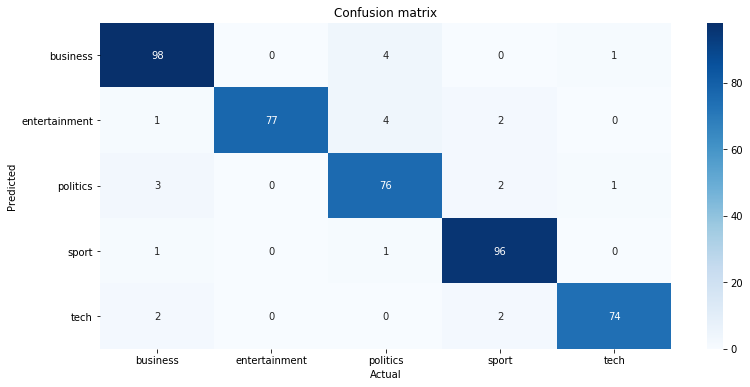

In [63]:
aux_df = df[['category', 'category_code']].drop_duplicates().sort_values('category_code')
conf_matrix = confusion_matrix(labels_test, predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['category'].values, 
            yticklabels=aux_df['category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [64]:
features = np.concatenate((features_train,features_test), axis=0)
labels = np.concatenate((labels_train,labels_test), axis=0)

In [65]:
print(features.shape)
print(labels.shape)

(2225, 300)
(2225,)


In [66]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "PCA decomposition"  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label'].astype(str)

    # Get labels name
    category_names = {
        "0": 'business',
        "1": 'entertainment',
        "2": 'politics',
        "3": 'sport',
        "4": 'tech'
    }

    # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})

    # Plot
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    palette=["red", "pink", "royalblue", "greenyellow", "lightseagreen"],
                    alpha=.7).set_title(title);

# Dimensionality reduction with PCA

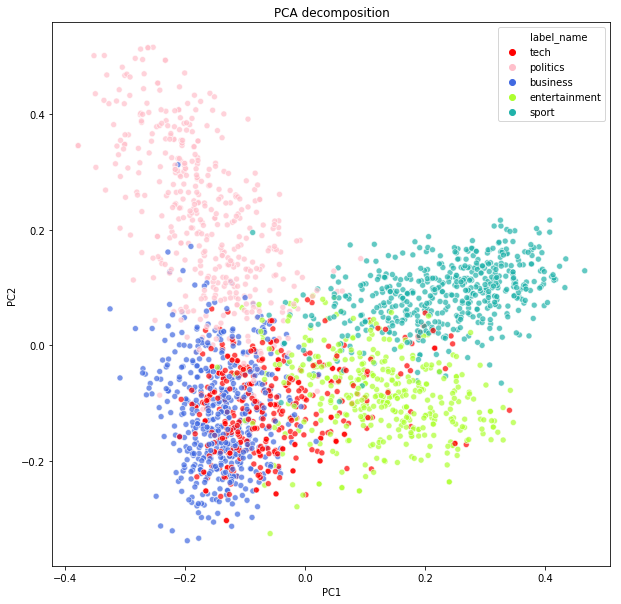

In [67]:
plot_dim_red("PCA", 
             features=features, 
             labels=labels,
             n_components=2)

# Dimensionality Reduction with t-SNE

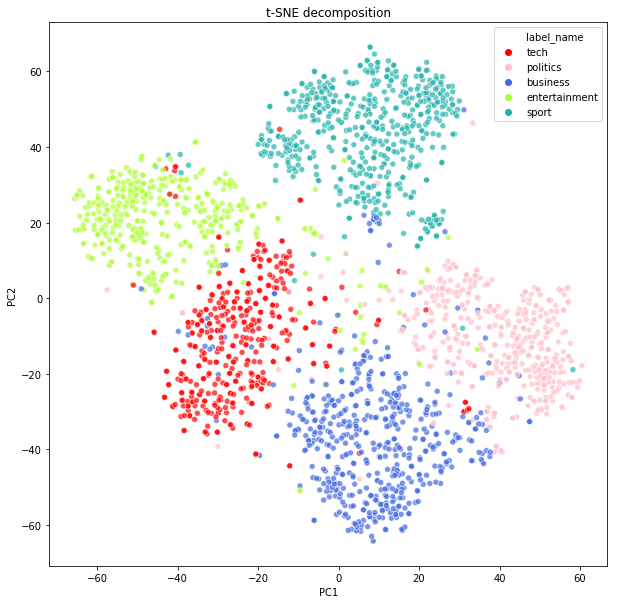

In [68]:
plot_dim_red("TSNE", 
             features=features, 
             labels=labels,
             n_components=2)